In [1]:
%matplotlib inline

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sn

import pycollocation

<h2>Example: Symmetric IPVP</h2>

After a bit of algebra, see <a href="https://github.com/davidrpugh/zice-2014/blob/master/solving-auctions/Hubbard%20and%20Paarsch%20(2013).pdf">Hubbard and Parsch (2013)</a> for details, all Symmetric Independent Private Values Paradigm (IPVP) models can be reduced down to a single non-linear ordinary differential equation (ODE) and an initial condition describing the behavior of the equilibrium bidding function $\sigma(v)$...

$$\sigma'(v) = \frac{(N - 1)vf(v)}{F(v)} - \frac{\sigma(v)(N-1)f(v)}{F(v)},\ \sigma(\underline{v}) = \underline{v} $$

...where $f$ and $F$ are the probability density function and the cumulative distribution function, respectively, for the valuations and $N$ is the number of bidders. 

In [14]:
import functools


class SymmetricIPVPModel(pycollocation.problems.IVP):
    
    def __init__(self, f, F, params):
        rhs = self._rhs_factory(f, F)
        super(SymmetricIPVPModel, self).__init__(self._initial_condition, 1, 1, params, rhs)
        
    @staticmethod
    def _initial_condition(v, sigma, v_lower, **params):
        return [sigma - v_lower]
    
    @staticmethod
    def _symmetric_ipvp_model(v, sigma, f, F, N, **params):
        return [(((N - 1) * f(v, **params)) / F(v, **params)) * (v - sigma)]
    
    @classmethod
    def _rhs_factory(cls, f, F):
        return functools.partial(cls._symmetric_ipvp_model, f=f, F=F)


In [82]:
def valuation_cdf(v, v_lower, v_upper, **params):
    return stats.uniform.cdf(v, v_lower, v_upper - v_lower)

def valuation_pdf(v, v_lower, v_upper, **params):
    return stats.uniform.pdf(v, v_lower, v_upper - v_lower)


In [83]:
params = {'v_lower': 1.0, 'v_upper': 2.0, 'N': 10}
symmetric_ipvp_ivp = SymmetricIPVPModel(valuation_pdf, valuation_cdf, params)

<h2>Solving the model with pyCollocation</h2>

### Finding a good initial guess for $\sigma(v)$

Theory tells us that bidding function should be monotonically increasing in the valuation? Higher valuations lead to higher bids?

In [80]:
def initial_mesh(domain, num, problem):
    """Guess that all participants bid their true valuations."""
    vs = np.linspace(domain[0], domain[1], num=num)
    return vs, vs


### Solving the model

In [10]:
pycollocation.solvers.Solver?

In [85]:
domain = [symmetric_ipvp_ivp.params['v_lower'], symmetric_ipvp_ivp.params['v_upper']]
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
solver = pycollocation.solvers.Solver(polynomial_basis)

basis_kwargs = {'kind': 'Chebyshev', 'domain': domain, 'degree': 3}

vs, sigmas = initial_mesh(basis_kwargs['domain'], 1000, symmetric_ipvp_ivp)
sigma_poly = polynomial_basis.fit(vs, sigmas, **basis_kwargs)
initial_coefs = sigma_poly.coef

solution = solver.solve(basis_kwargs, initial_coefs, symmetric_ipvp_ivp)


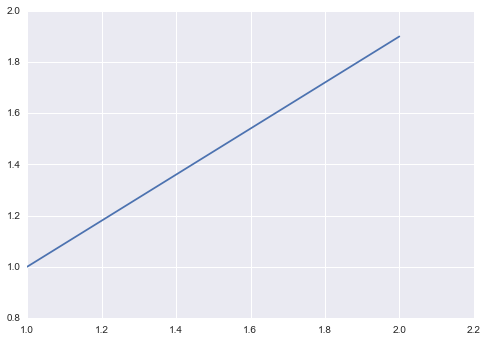

In [86]:
sigma_soln, = solution.evaluate_solution(vs)
plt.plot(vs, sigma_soln)
plt.show()

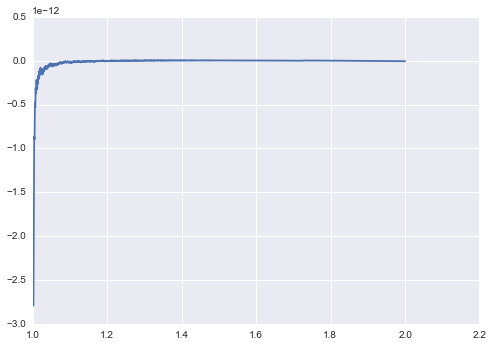

In [87]:
sigma_resids, = solution.evaluate_residual(vs)
plt.plot(vs, sigma_resids)
plt.show()

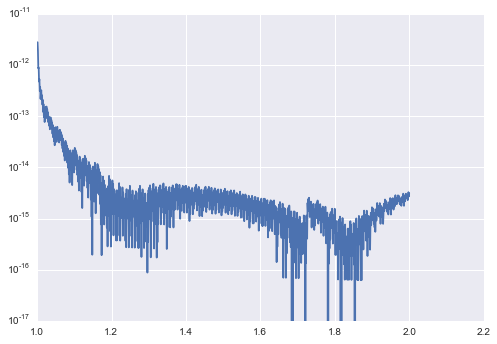

In [88]:
sigma_normalized_resids, = solution.normalize_residuals(vs)
plt.plot(vs, np.abs(sigma_normalized_resids))
plt.yscale('log')
plt.show()

In [69]:
def analytic_solution(v, N, v_lower, v_upper, **params):
    """
    Solution for symmetric IVPVP auction with uniform valuations.
    
    Notes
    -----
    There is a generic closed form solution for this class of auctions.
    Annoyingly it involves integrating a function of the cumulative
    distribution function for valuations.

    """
    return v - (1.0 / N) * valuation_cdf(v, v_lower, v_upper)

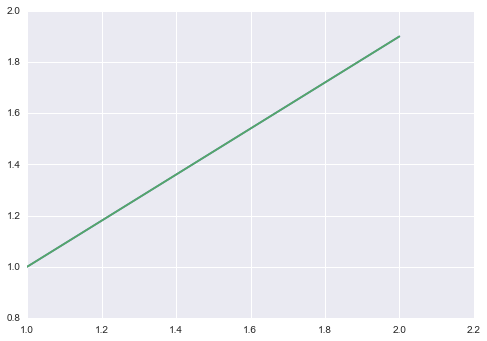

In [70]:
plt.plot(vs, analytic_solution(vs, **symmetric_ipvp_ivp.params))
plt.plot(vs, sigma_soln)
plt.show()

<h2>Example: Asymmetric IPVP</h2>

After a bit of algebra, see <a href="https://github.com/davidrpugh/zice-2014/blob/master/solving-auctions/Hubbard%20and%20Paarsch%20(2013).pdf">Hubbard and Parsch (2013)</a> for details, all Asymmetric Independent Private Values Paradigm (IPVP) models can be reduced down to a system of non-linear ordinary differential equations (ODEs) and associated boundary conditions...

\begin{align}
    \phi'(s) =& \frac{F_n(\phi_n(s))}{f_n(\phi_n(s))}\Bigg[\frac{1}{N-1}\sum_{m=1}^N \frac{1}{\phi_m(s) - s} - \frac{1}{\phi_n(s)}\Bigg] \ \forall n=1,\dots,N \\
    \phi(\underline{s}) =& \underline{v}\ \forall n=1,\dots,N \\
    \phi(\overline{s}) = & \overline{v}\ \forall n=1,\dots,N
\end{align}

...where $f_n$ and $F_n$ are the probability density function and the cumulative distribution function, respectively, for the valuation of bidder $n$ and $N$ is the number of bidders. 

In [75]:
def rhs_bidder_n(n, s, phis, f, F, N, **params):
    A = (F(phis[n], **params) / f(phis[n], **params))
    B = ((1 / (N - 1)) * sum(1 / (phi(s) - s) for phi in phis) - (1 / phis[n]))
    return A * B

In [76]:
def asymmetric_ipvp_model(s, *phis, fs=None, Fs=None, N=2, **params):
    return [rhs_bidder(n, s, phi, f, F, N, **params) for phi, f, F in zip(phis, fs, Fs)]

SyntaxError: invalid syntax (<ipython-input-76-ea9c9b17a7c9>, line 1)

To be continued...solving this model will require:

1. the ability to specify a free boundary condition
2. the ability to solver over-determined systems